# Ungraded Lab: Effect of Compacted Images in Training

In this notebook, you will see how reducing the target size of the image datasets will affect the architecture and performance of your model. This is a useful technique in case you need to speed up your training or save compute resources. Let's begin!

## Import the Libraries

Start with importing all the libraries you will need.

In [1]:
import os
import random
import numpy as np
from io import BytesIO

# Plotting and dealing with images
import matplotlib.pyplot as plt

import tensorflow as tf

# Interactive widgets
from ipywidgets import widgets

## Load the Dataset

Define the directories containing the images:

In [2]:
TRAIN_DIR = 'horse-or-human'
VAL_DIR = 'validation-horse-or-human'

# Directory with training horse pictures
train_horse_dir = os.path.join(TRAIN_DIR, 'horses')

# Directory with training human pictures
train_human_dir = os.path.join(TRAIN_DIR, 'humans')

# Directory with validation horse pictures
validation_horse_dir = os.path.join(VAL_DIR, 'horses')

# Directory with validation human pictures
validation_human_dir = os.path.join(VAL_DIR, 'humans')

You can check that the directories are not empty and that the train set has more images than the validation set:

In [3]:
train_horse_names = os.listdir(train_horse_dir)
print(f'TRAIN SET HORSES: {train_horse_names[:10]}')

train_human_names = os.listdir(train_human_dir)
print(f'TRAIN SET HUMANS: {train_human_names[:10]}')

validation_horse_hames = os.listdir(validation_horse_dir)
print(f'VAL SET HORSES: {validation_horse_hames[:10]}')

validation_human_names = os.listdir(validation_human_dir)
print(f'VAL SET HUMANS: {validation_human_names[:10]}')

TRAIN SET HORSES: ['horse38-4.png', 'horse34-8.png', 'horse17-7.png', 'horse15-9.png', 'horse36-6.png', 'horse19-5.png', 'horse39-3.png', 'horse18-6.png', 'horse35-7.png', 'horse16-8.png']
TRAIN SET HUMANS: ['human12-13.png', 'human03-22.png', 'human01-06.png', 'human06-10.png', 'human15-01.png', 'human04-30.png', 'human05-02.png', 'human13-21.png', 'human11-05.png', 'human02-14.png']
VAL SET HORSES: ['horse5-235.png', 'horse5-550.png', 'horse1-554.png', 'horse6-153.png', 'horse5-514.png', 'horse3-255.png', 'horse1-455.png', 'horse5-181.png', 'horse2-544.png', 'horse5-002.png']
VAL SET HUMANS: ['valhuman04-00.png', 'valhuman01-12.png', 'valhuman02-20.png', 'valhuman02-02.png', 'valhuman03-10.png', 'valhuman01-21.png', 'valhuman03-01.png', 'valhuman02-11.png', 'valhuman01-03.png', 'valhuman04-08.png']


In [4]:
print(f'total training horse images: {len(os.listdir(train_horse_dir))}')
print(f'total training human images: {len(os.listdir(train_human_dir))}')
print(f'total validation horse images: {len(os.listdir(validation_horse_dir))}')
print(f'total validation human images: {len(os.listdir(validation_human_dir))}')

total training horse images: 500
total training human images: 527
total validation horse images: 128
total validation human images: 128


## Build the Model

The model will follow the same architecture as before but they key difference is in the `input_shape` parameter of the first `Conv2D` layer. Since you will be compacting the images later when you define the `tf.data` datasets, you need to specify the expected image size here. Instead of 300x300 as in the previous two labs, you will specify a smaller 150x150 array.

In [5]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution (You can comment the 4th and 5th conv layers later to see how it affects the results)
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0 to 1 where 0 is for 'horses' and 1 for 'humans'
    tf.keras.layers.Dense(1, activation='sigmoid')
])

You can see the difference from previous models when you print the `model.summary()`.

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

You will use the same settings for training:

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

### Data Preprocessing

Now you will instantiate the datasets. As mentioned before, you will be compacting the image by specifying the `target_size` parameter. See the simple change below:

In [8]:
# Instantiate the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    './horse-or-human/',
    image_size=(150, 150),
    batch_size=32,
    label_mode='binary'
    )

# Instantiate the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    './validation-horse-or-human/',
    image_size=(150, 150),
    batch_size=32,
    label_mode='binary'
    )

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


As before, you will rescale the images and set them up for training.

In [9]:
# Define the rescaling layer
rescale_layer = tf.keras.layers.Rescaling(1./255)

# Rescale both datasets
train_dataset_scaled = train_dataset.map(lambda image, label: (rescale_layer(image), label))
validation_dataset_scaled = validation_dataset.map(lambda image, label: (rescale_layer(image), label))

SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

# Configure the training set
train_dataset_final = (train_dataset_scaled
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                      )

# Configure the validation dataset
validation_dataset_final = (validation_dataset_scaled
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                           )

### Training

Now you're ready to train and see the results. Note your observations about how fast the model trains and the accuracies you're getting in the train and validation sets.

In [10]:
history = model.fit(
      train_dataset_final,
      epochs=15,
      validation_data = validation_dataset_final,
      verbose=2)

Epoch 1/15


I0000 00:00:1744418869.458735     226 service.cc:145] XLA service 0x71f6e8003fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744418869.458847     226 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
I0000 00:00:1744418871.622845     226 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 - 7s - 208ms/step - accuracy: 0.6300 - loss: 0.8395 - val_accuracy: 0.8164 - val_loss: 0.4267
Epoch 2/15
33/33 - 0s - 6ms/step - accuracy: 0.8598 - loss: 0.3441 - val_accuracy: 0.8711 - val_loss: 0.5471
Epoch 3/15
33/33 - 0s - 6ms/step - accuracy: 0.9464 - loss: 0.1369 - val_accuracy: 0.6992 - val_loss: 1.8924
Epoch 4/15
33/33 - 0s - 6ms/step - accuracy: 0.9192 - loss: 0.2365 - val_accuracy: 0.8555 - val_loss: 0.7122
Epoch 5/15
33/33 - 0s - 6ms/step - accuracy: 0.9766 - loss: 0.0685 - val_accuracy: 0.8359 - val_loss: 0.9662
Epoch 6/15
33/33 - 0s - 6ms/step - accuracy: 0.9873 - loss: 0.0416 - val_accuracy: 0.7305 - val_loss: 3.3759
Epoch 7/15
33/33 - 0s - 6ms/step - accuracy: 0.9679 - loss: 0.5392 - val_accuracy: 0.7617 - val_loss: 1.7524
Epoch 8/15
33/33 - 0s - 6ms/step - accuracy: 0.9834 - loss: 0.0384 - val_accuracy: 0.8594 - val_loss: 1.0612
Epoch 9/15
33/33 - 0s - 6ms/step - accuracy: 0.9834 - loss: 0.0387 - val_accuracy: 0.8320 - val_loss: 1.4103
Epoch 10/15
33/33 - 0s - 6ms

Plot the training and validation accuracies:

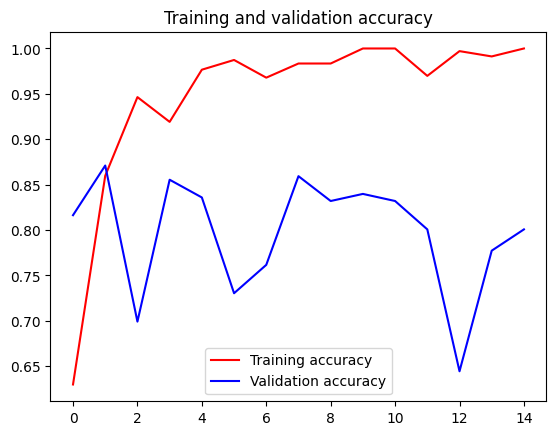

In [11]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

### Model Prediction

As usual, it is also good practice to try running your model over some handpicked images. See if you got better, worse, or the same performance as the previous lab.

In [12]:
# Create the widget and take care of the display
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image, verbose=0)[0][0]
    
    with out:
        if prediction > 0.5:
            print(filename + " is a human")
        else:
            print(filename + " is a horse")


def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)
    
    items = change.new
    for item in items: # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)

# Run the interactive widget
# Note: it may take a bit after you select the image to upload and process before you see the output.
uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

### Visualizing Intermediate Representations

You can also look again at the intermediate representations. You will notice that the output at the last convolution layer is even more abstract because it contains fewer pixels than before.

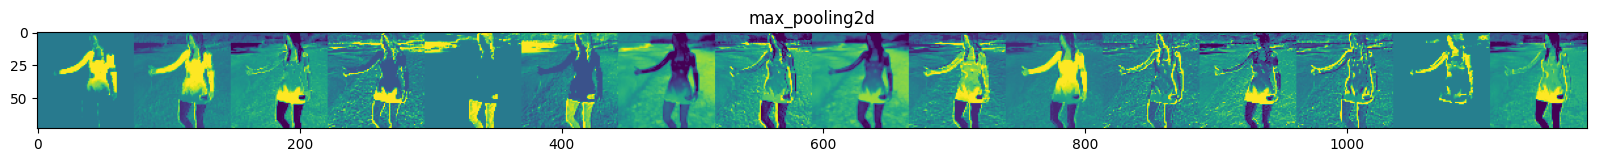

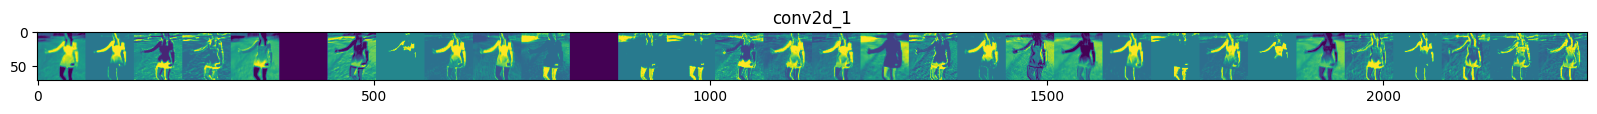

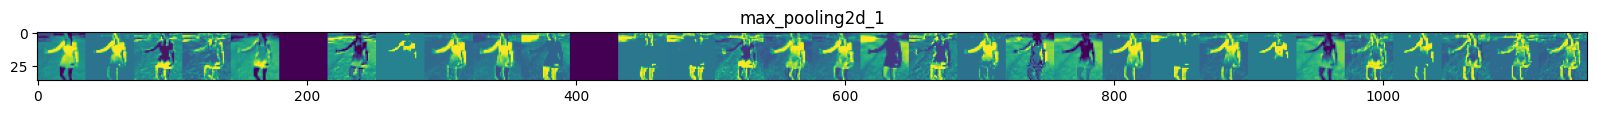

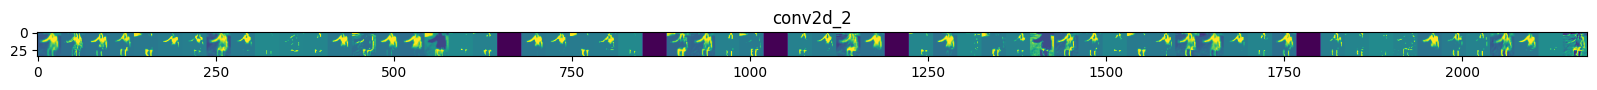

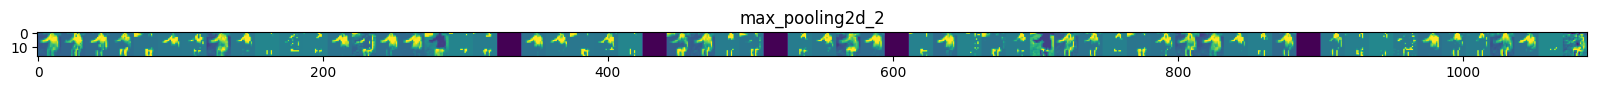

In [13]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.inputs, outputs = successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)
img = tf.keras.utils.load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = tf.keras.utils.img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
# Since you are not using a tf.data.Dataset you apply the normalization via a simple numpy vectorization
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x, verbose=False)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]

    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')

      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Wrap Up

In this lab, you saw how compacting images affected your previous model. This is one technique to keep in mind especially when you are still in the exploratory phase of your own projects. You can see if a smaller model behaves just as well as a large model so you can have faster training. You also saw how easy it is to customize your images for this adjustment in size by simply changing a parameter in the `image_dataset_from_directory` method.